In [ ]:
# Install required libraries
!pip install transformers

import torch
from transformers import BlipProcessor, BlipForConditionalGeneration, BlipForImageTextRetrieval, BlipForQuestionAnswering
from PIL import Image
import requests
import matplotlib.pyplot as plt

In [ ]:

# Function to display image
def display_image(image_url, title=None):
    image = Image.open(requests.get(image_url, stream=True).raw)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Function to apply softmax to logits
def softmax(logits):
    exp_logits = np.exp(logits)
    return exp_logits / np.sum(exp_logits)

# Function to display images in a single row with scores
def display_images_with_scores(image_urls, scores, query_text):
    plt.figure(figsize=(20, 5))
    for i, (url, score) in enumerate(zip(image_urls, scores)):
        image = Image.open(requests.get(url, stream=True).raw)
        plt.subplot(1, len(image_urls), i + 1)
        plt.imshow(image)
        plt.title(f"Match: {score:.2%}")
        plt.axis('off')
    plt.suptitle(query_text, fontsize=16)
    plt.show()

In [ ]:
# Initialize the processor and model
captioning_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
retrieval_model = BlipForImageTextRetrieval.from_pretrained("Salesforce/blip-itm-base-coco")
vqa_model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/895M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/895M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
processor

BlipProcessor:
- image_processor: BlipImageProcessor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "do_convert_rgb",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "BlipImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "processor_class": "BlipProcessor",
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 384,
    "width": 384
  }
}

- tokenizer: BertTokenizerFast(name_or_path='Salesforce/blip-image-captioning-base', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[S

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


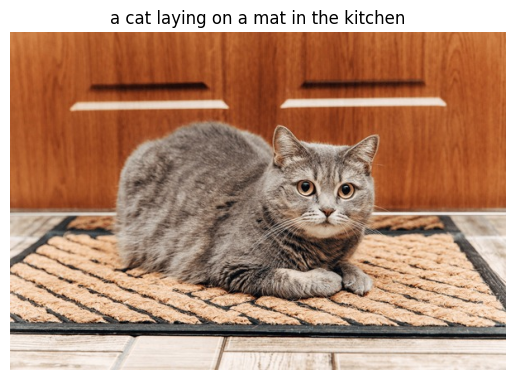

In [ ]:
# Task 1: Image Captioning
image_url = "https://www.shutterstock.com/image-photo/scottish-gray-catsitting-on-entrance-600nw-1210863730.jpg" # Replace with an actual image URL
image = Image.open(requests.get(image_url, stream=True).raw)

inputs = processor(images=image, return_tensors="pt")
out = captioning_model.generate(**inputs)
caption = processor.decode(out[0], skip_special_tokens=True)
display_image(image_url, title=caption)

In [ ]:
out.shape

torch.Size([1, 11])

ITM Scores:
A cat sitting on a mat: tensor([-2.5051,  2.5032])
A cat sleeping: tensor([ 2.7586, -2.7545])
A cat playing in the park.: tensor([ 4.1003, -4.0959])
A beautiful sunset over the ocean.: tensor([ 5.7190, -5.7182])


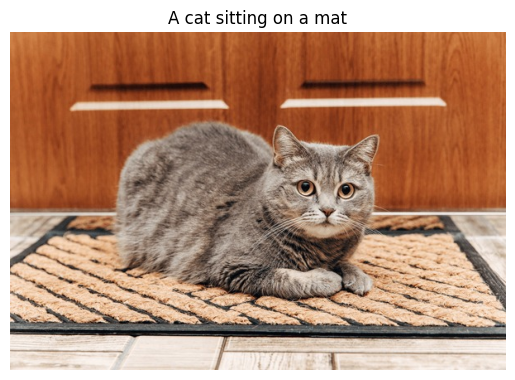

In [ ]:
# Task 2: Image-to-Text Retrieval
image_url = "https://www.shutterstock.com/image-photo/scottish-gray-catsitting-on-entrance-600nw-1210863730.jpg" # Replace with an actual image URL
text_corpus = ["A cat sitting on a mat", "A cat sleeping", "A cat playing in the park.", "A beautiful sunset over the ocean."]

image = Image.open(requests.get(image_url, stream=True).raw)
text_inputs = processor(text=text_corpus, return_tensors="pt", padding=True, truncation=True)
image_inputs = processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = retrieval_model(**image_inputs, **text_inputs)
    itm_scores = outputs.itm_score  # ITM scores for each pair

# Debug: Print itm_scores and corresponding text
print("ITM Scores:")
for score, text in zip(itm_scores, text_corpus):
    print(f"{text}: {score}")

# Select the best match based on the highest score for the match class (index 1)
best_idx = itm_scores[:, 1].argmax().item()
best_match = text_corpus[best_idx]

display_image(image_url, title=best_match)

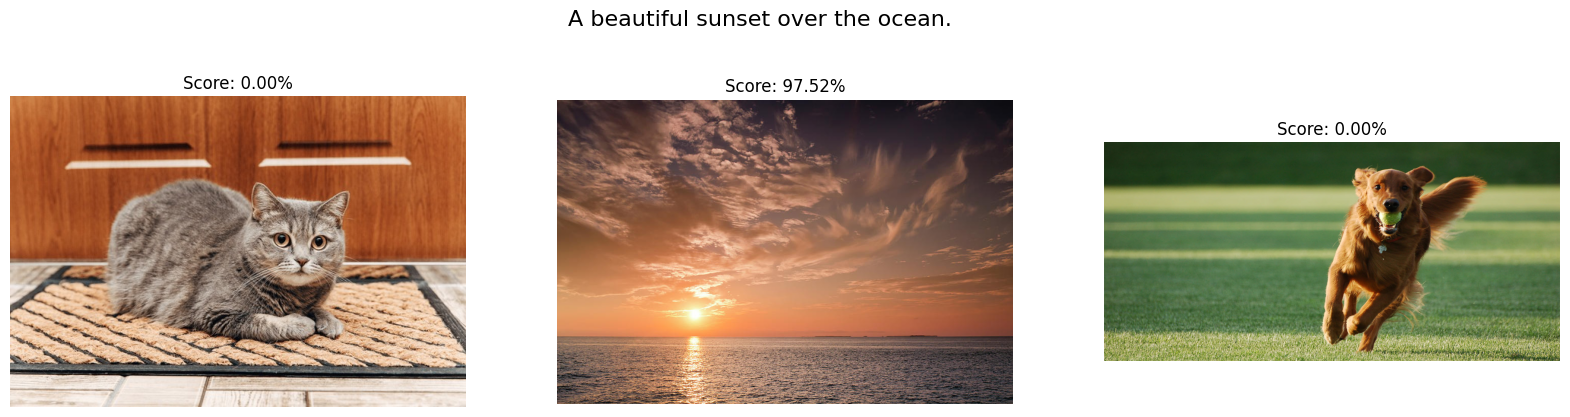

In [ ]:
# Task 3: Text-to-Image Retrieval
query_text = "A beautiful sunset over the ocean."
image_urls = [
    "https://www.shutterstock.com/image-photo/scottish-gray-catsitting-on-entrance-600nw-1210863730.jpg", # Replace with actual image URLs
    "https://images.fineartamerica.com/images-medium-large-5/1-beautiful-sunset-over-the-ocean-waters-ricardoreitmeyer.jpg",
    "https://wharfedaledoggyplaypark.co.uk/wp-content/uploads/2016/02/Wharfedale-doggy-play-park-happy-dogs.jpg"
]

text_inputs = processor(text=query_text, return_tensors="pt")
images = [Image.open(requests.get(url, stream=True).raw) for url in image_urls]
image_inputs = processor(images=images, return_tensors="pt", padding=True)

with torch.no_grad():
    outputs = retrieval_model(**image_inputs, **text_inputs)
    itm_scores = outputs.itm_score  # ITM scores for each pair

# Apply softmax to the match class logits to get probabilities
match_scores = torch.softmax(itm_scores, dim=1)[:, 1].cpu().numpy()

# Display each image with its softmax score in a single row
display_images_with_scores(image_urls, match_scores, query_text)

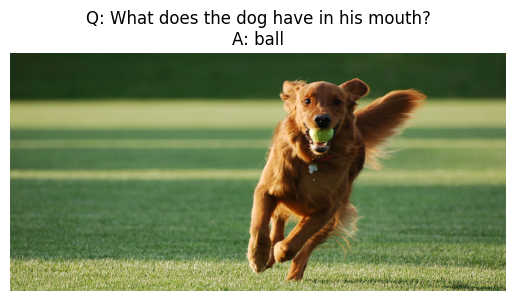

In [ ]:
# Task 4: Visual Question Answering
question = "What does the dog have in his mouth?"
image_url = "https://wharfedaledoggyplaypark.co.uk/wp-content/uploads/2016/02/Wharfedale-doggy-play-park-happy-dogs.jpg"
image = Image.open(requests.get(image_url, stream=True).raw)

inputs = processor(images=image, text=question, return_tensors="pt")

with torch.no_grad():
    outputs = vqa_model.generate(**inputs)
    answer = processor.decode(outputs[0], skip_special_tokens=True)

display_image(image_url, title=f"Q: {question}\nA: {answer}")